In [1]:
import pandas as pd
import numpy as np
import nltk
import multiprocessing
import difflib
import time
import gc
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import category_encoders as ce

from collections import Counter
from sklearn.metrics import log_loss
from scipy.optimize import minimize
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import cosine, correlation, canberra, chebyshev, minkowski, jaccard, euclidean

from models_utils_xgb import *

In [2]:
def get_train():
    feats_src = '/media/w/1c392724-ecf3-4615-8f3c-79368ec36380/DS Projects/Kaggle/Quora/data/features/uncleaned/'
    keras_q1 = np.load(feats_src + 'train_q1_transformed.npy')
    keras_q2 = np.load(feats_src + 'train_q2_transformed.npy')
    
    feats_src2 = '/media/w/1c392724-ecf3-4615-8f3c-79368ec36380/DS Projects/Kaggle/Quora/data/features/NER/'
    keras_q1 = np.load(feats_src2 + 'q1train_NER_128len.npy')
    keras_q2 = np.load(feats_src2 + 'q2train_NER_128len.npy')
    
    xgb_feats = pd.read_csv(feats_src + '/the_1owl/owl_train.csv')
    abhishek_feats = pd.read_csv(feats_src + 'abhishek/train_features.csv',
                              encoding = 'ISO-8859-1').iloc[:, 2:]
    text_feats = pd.read_csv(feats_src + 'other_features/text_features_train.csv',
                            encoding = 'ISO-8859-1')
    img_feats = pd.read_csv(feats_src + 'other_features/img_features_train.csv')
    srk_feats = pd.read_csv(feats_src + 'srk/SRK_grams_features_train.csv')
    
    mephisto_feats = pd.read_csv('../../data/features/lemmatized_fullclean/train_mephistopeheles_features.csv').iloc[:, 6:]
    turkewitz_feats = pd.read_csv('../../data/features/lemmatized_fullclean/train_turkewitz_features_fullcleanSTEMMED.csv')
    #turkewitz_feats = pd.read_csv(feats_src + 'other_features/train_turkewitz_feats_orig.csv')
    turkewitz_feats = turkewitz_feats[['q1_freq', 'q2_freq']]
    turkewitz_feats['freq_sum'] = turkewitz_feats.q1_freq + turkewitz_feats.q2_freq
    turkewitz_feats['freq_diff'] = turkewitz_feats.q1_freq - turkewitz_feats.q2_freq
    turkewitz_feats['freq_mult'] = turkewitz_feats.q1_freq * turkewitz_feats.q2_freq
    turkewitz_feats['freq_div'] = turkewitz_feats.q1_freq / turkewitz_feats.q2_freq
    
    xgb_feats.drop(['z_len1', 'z_len2', 'z_word_len1', 'z_word_len2'], axis = 1, inplace = True)
    y_train = xgb_feats['is_duplicate']
    xgb_feats = xgb_feats.iloc[:, 8:]
    
    df = pd.concat([xgb_feats, abhishek_feats, text_feats, img_feats, 
                               turkewitz_feats, mephisto_feats], axis = 1)
    df = pd.DataFrame(df)
    dfc = df.iloc[0:1000,:]
    dfc = dfc.T.drop_duplicates().T
    duplicate_cols = sorted(list(set(df.columns).difference(set(dfc.columns))))
    print('Dropping duplicate columns:', duplicate_cols)
    df.drop(duplicate_cols, axis = 1, inplace = True)
    print('Final shape:', df.shape)
    
    keras_q1 = pd.DataFrame(keras_q1)
    keras_q2 = pd.DataFrame(keras_q2)
    keras_q1.columns = ['question1_{}'.format(i) for i in range(keras_q1.shape[1])]
    keras_q2.columns = ['question2_{}'.format(i) for i in range(keras_q2.shape[1])]
    X = pd.concat([keras_q1, keras_q2, df], axis = 1)
    #X = np.concatenate([keras_q1, keras_q2, df.values], axis = 1)
    #X = X.astype('float32')
    print('Training data shape:', X.shape)
    return X, y_train

def labelcount_encode(df2, cols):
    df = df2.copy()
    categorical_features = cols
    new_df = pd.DataFrame()
    for cat_feature in categorical_features:
        cat_feature_value_counts = df[cat_feature].value_counts()
        value_counts_list = cat_feature_value_counts.index.tolist()
        value_counts_range_rev = list(reversed(range(len(cat_feature_value_counts)))) # for ascending ordering
        value_counts_range = list(range(len(cat_feature_value_counts))) # for descending ordering
        labelcount_dict = dict(zip(value_counts_list, value_counts_range))
        new_df[cat_feature] = df[cat_feature].map(labelcount_dict)
    return new_df

def count_encode(df2, cols):
    df = df2.copy()
    categorical_features = cols
    new_df = pd.DataFrame()
    for i in categorical_features:
        new_df[i] = df[i].astype('object').replace(df[i].value_counts())
    return new_df

def bin_numerical(df2, cols, step):
    df = df2.copy()
    numerical_features = cols
    new_df = pd.DataFrame()
    for i in numerical_features:
        feature_range = np.arange(0, np.max(df[i]), step)
        new_df[i] = np.digitize(df[i], feature_range, right=True)
    return new_df

In [3]:
def train_xgb(cv = False):
    
    t = time.time()
    params = {
    'seed': 1337,
    'colsample_bytree': 0.48,
    'silent': 1,
    'subsample': 0.74,
    'eta': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 12,
    'min_child_weight': 20,
    'nthread': 8,
    'tree_method': 'hist',
    #'updater': 'grow_gpu',
    }
    
    X_train, y_train = get_train()
    
    if cv:
        dtrain = xgb.DMatrix(X_train, y_train)
        hist = xgb.cv(params, dtrain, num_boost_round = 100000, nfold = 5,
                      stratified = True, early_stopping_rounds = 350, verbose_eval = 250,
                      seed = 1337)
        del X_train, y_train
        gc.collect()
        print('Time it took to train in CV manner:', time.time() - t)
        return hist
    
    else:
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify = y_train,
                                                    test_size = 0.2, random_state = 111)
        del X_train, y_train
        gc.collect()
        dtrain = xgb.DMatrix(X_tr, label = y_tr)
        dval = xgb.DMatrix(X_val, label = y_val)
        watchlist = [(dtrain, 'train'), (dval, 'valid')]

        print('Start training...')
        gbm = xgb.train(params, dtrain, 100000, watchlist, 
                        early_stopping_rounds = 350, verbose_eval = 100)

        print('Start predicting...')
        val_pred = gbm.predict(xgb.DMatrix(X_val), ntree_limit=gbm.best_ntree_limit)
        score = log_loss(y_val, val_pred)
        print('Final score:', score, '\n', 'Time it took to train and predict:', time.time() - t)
        
        del X_tr, X_val, y_tr, y_val
        gc.collect()
        return gbm
    

def run_xgb(model_name, train = True, test = False, cv = False):
    if cv:
        gbm_hist = train_xgb(True)
        return gbm_hist
    if train:
        gbm = train_xgb()
        gbm.save_model('saved_models/XGB/{}.txt'.format(model_name))
        if test:
            predict_test('{}'.format(model_name))
        return gbm

In [4]:
def get_transformations_features(transformations_src, mode = 'train'):
    print('Adding features based on data transformations.')
    lsa10tr_3grams_q1 = np.load(transformations_src + '{}_lsa10_3grams.npy'.format(mode))[0]
    lsa10tr_3grams_q2 = np.load(transformations_src + '{}_lsa10_3grams.npy'.format(mode))[1]
    
    transforms_feats = pd.DataFrame()
    transforms_feats['cosine'] = [cosine(x, y) for (x,y) in zip(lsa10tr_3grams_q1, lsa10tr_3grams_q2)]
    transforms_feats['correlation'] = [correlation(x, y) for (x,y) in zip(lsa10tr_3grams_q1, lsa10tr_3grams_q2)]
    transforms_feats['jaccard'] = [jaccard(x, y) for (x,y) in zip(lsa10tr_3grams_q1, lsa10tr_3grams_q2)]
    transforms_feats['euclidean'] = [euclidean(x, y) for (x,y) in zip(lsa10tr_3grams_q1, lsa10tr_3grams_q2)]
    transforms_feats['minkowski'] = [minkowski(x, y, 3) for (x,y) in zip(lsa10tr_3grams_q1, lsa10tr_3grams_q2)]
    return transforms_feats

def get_doc2vec_features(doc2vec_src, mode = 'train'):
    print('Adding features based on Doc2Vec distances.')
    doc2vec_pre_q1 = np.load(doc2vec_src + '{}_q1_doc2vec_vectors_pretrained.npy'.format(mode))
    doc2vec_pre_q2 = np.load(doc2vec_src + '{}_q2_doc2vec_vectors_pretrained.npy'.format(mode))
    doc2vec_quora_q1 = np.load(doc2vec_src + '{}_q1_doc2vec_vectors_trainquora.npy'.format(mode))
    doc2vec_quora_q2 = np.load(doc2vec_src + '{}_q2_doc2vec_vectors_trainquora.npy'.format(mode))
    
    d2v_feats_pretrained = pd.DataFrame()
    d2v_feats_pretrained['cosine'] = [cosine(x, y) for (x,y) in zip(doc2vec_pre_q1, doc2vec_pre_q2)]
    d2v_feats_pretrained['correlation'] = [correlation(x, y) for (x,y) in zip(doc2vec_pre_q1, doc2vec_pre_q2)]
    d2v_feats_pretrained['jaccard'] = [jaccard(x, y) for (x,y) in zip(doc2vec_pre_q1, doc2vec_pre_q2)]
    d2v_feats_pretrained['euclidean'] = [euclidean(x, y) for (x,y) in zip(doc2vec_pre_q1, doc2vec_pre_q2)]
    d2v_feats_pretrained['minkowski'] = [minkowski(x, y, 3) for (x,y) in zip(doc2vec_pre_q1, doc2vec_pre_q2)]
    
    d2v_feats_quora = pd.DataFrame()
    d2v_feats_quora['cosine'] = [cosine(x, y) for (x,y) in zip(doc2vec_quora_q1, doc2vec_quora_q2)]
    d2v_feats_quora['correlation'] = [correlation(x, y) for (x,y) in zip(doc2vec_quora_q1, doc2vec_quora_q2)]
    d2v_feats_quora['jaccard'] = [jaccard(x, y) for (x,y) in zip(doc2vec_quora_q1, doc2vec_quora_q2)]
    d2v_feats_quora['euclidean'] = [euclidean(x, y) for (x,y) in zip(doc2vec_quora_q1, doc2vec_quora_q2)]
    d2v_feats_quora['minkowski'] = [minkowski(x, y, 3) for (x,y) in zip(doc2vec_quora_q1, doc2vec_quora_q2)]
    return d2v_feats_pretrained, d2v_feats_quora

def labelcount_encode(df2, cols):
    df = df2.copy()
    categorical_features = cols
    new_df = pd.DataFrame()
    for cat_feature in categorical_features:
        cat_feature_value_counts = df[cat_feature].value_counts()
        value_counts_list = cat_feature_value_counts.index.tolist()
        value_counts_range_rev = list(reversed(range(len(cat_feature_value_counts)))) # for ascending ordering
        value_counts_range = list(range(len(cat_feature_value_counts))) # for descending ordering
        labelcount_dict = dict(zip(value_counts_list, value_counts_range))
        new_df[cat_feature] = df[cat_feature].map(labelcount_dict)
    return new_df

def count_encode(df2, cols):
    df = df2.copy()
    categorical_features = cols
    new_df = pd.DataFrame()
    for i in categorical_features:
        new_df[i] = df[i].astype('object').replace(df[i].value_counts())
    return new_df

def bin_numerical(df2, cols, step):
    df = df2.copy()
    numerical_features = cols
    new_df = pd.DataFrame()
    for i in numerical_features:
        feature_range = np.arange(0, np.max(df[i]), step)
        new_df[i] = np.digitize(df[i], feature_range, right=True)
    return new_df

In [5]:
#turkewitz_feats = pd.read_csv('/media/w/1c392724-ecf3-4615-8f3c-79368ec36380/DS Projects/Kaggle/Quora/data/features/uncleaned_data/other_features/train_turkewitz_feats_orig.csv')
turkewitz_feats = pd.read_csv('/media/w/1c392724-ecf3-4615-8f3c-79368ec36380/DS Projects/Kaggle/Quora/data/features/lemmatized_fullclean/train_turkewitz_features_fullcleanSTEMMED.csv')
turkewitz_feats = turkewitz_feats[['q1_freq', 'q2_freq']]

ff1 = turkewitz_feats.groupby(['q2_freq'])['q1_freq'].transform('sum')
ff2 = turkewitz_feats.groupby(['q1_freq'])['q2_freq'].transform('sum')
ff1 = ff1 / np.max(ff1)
ff2 = ff2 / np.max(ff2)
ff1m = turkewitz_feats.groupby(['q2_freq'])['q1_freq'].transform('mean')
ff2m = turkewitz_feats.groupby(['q1_freq'])['q2_freq'].transform('mean')
ff1m = ff1m / np.max(ff1m)
ff2m = ff2m / np.max(ff2m)
gr_feats = pd.DataFrame()
gr_feats['ff1'] = ff1
gr_feats['ff2'] = ff2
gr_feats['ff1m'] = ff1m
gr_feats['ff2m'] = ff2m

train_c = count_encode(turkewitz_feats, ['q1_freq', 'q2_freq'])
train_c.q1_freq = train_c.q1_freq / np.max(train_c.q1_freq)
train_c.q2_freq = train_c.q2_freq / np.max(train_c.q2_freq)
train_c.rename(columns = {'q1_freq': 'q2_freq_normalized', 'q2_freq': 'q2_freq_normalized'}, inplace = True)

src = '/media/w/1c392724-ecf3-4615-8f3c-79368ec36380/DS Projects/Kaggle/Quora/scripts/features/'
network_feats =  pd.read_csv(src + 'train_networkfeats_fullclean.csv')

new_feats = pd.concat([train_c, gr_feats, network_feats], axis = 1)

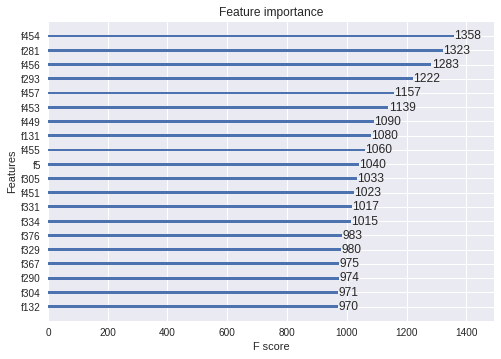

In [6]:
gbm = xgb.Booster(model_file = 'saved_models/XGB/XGB_new_NetworkFeats.txt')
xgb.plot_importance(gbm, max_num_features = 20)

In [7]:
X_train, y_train = get_train()

X_train = pd.concat([X_train, new_feats], axis = 1)
print('Final shape:', X_train.shape)

Dropping duplicate columns: ['duplicated', 'len1', 'len2', 'm_q1_q2_tf_svd1']
Final shape: (404290, 203)
Training data shape: (404290, 459)
Final shape: (404290, 473)


In [8]:
X_train['q1_deg_by_freq'] = X_train.groupby(['q1_freq'])['q1_degrees'].transform('mean')
X_train['q2_deg_by_freq'] = X_train.groupby(['q2_freq'])['q2_degrees'].transform('mean')

X_train['q1_deg_by_freq2'] = X_train.groupby(['q1_freq'])['q2_degrees'].transform('mean')
X_train['q2_deg_by_freq1'] = X_train.groupby(['q2_freq'])['q1_degrees'].transform('mean')

X_train['q1_clust_by_freq'] = X_train.groupby(['q1_freq'])['q1_cluster'].transform('mean')
X_train['q2_clust_by_freq'] = X_train.groupby(['q2_freq'])['q2_cluster'].transform('mean')

X_train['q1_clust_by_freq2'] = X_train.groupby(['q1_freq'])['q2_cluster'].transform('mean')
X_train['q2_clust_by_freq1'] = X_train.groupby(['q2_freq'])['q1_cluster'].transform('mean')

X_train['q1_deg_by_freq_inv'] = X_train.groupby(['q1_degrees'])['q1_freq'].transform('mean')
X_train['q2_deg_by_freq_inv'] = X_train.groupby(['q2_degrees'])['q2_freq'].transform('mean')

X_train['q1_deg_by_freq2_inv'] = X_train.groupby(['q2_degrees'])['q1_freq'].transform('mean')
X_train['q2_deg_by_freq1_inv'] = X_train.groupby(['q1_degrees'])['q2_freq'].transform('mean')

X_train['q1_clust_by_freq_inv'] = X_train.groupby(['q1_cluster'])['q1_freq'].transform('mean')
X_train['q2_clust_by_freq_inv'] = X_train.groupby(['q2_cluster'])['q2_freq'].transform('mean')

X_train['q1_clust_by_freq2_inv'] = X_train.groupby(['q2_cluster'])['q1_freq'].transform('mean')
X_train['q2_clust_by_freq1_inv'] = X_train.groupby(['q1_cluster'])['q2_freq'].transform('mean')


In [9]:
d2v_pre = np.load('train_doc2vec_pretrained_distances.npy')
d2v_quora = np.load('train_doc2vec_quoratrain_distances.npy')
transforms = np.load('train_transformations_distances.npy')

X_train = np.concatenate([X_train, d2v_pre, d2v_quora, transforms], axis = 1)
X_train = X_train.astype('float32')
print('Final shape:', X_train.shape)

Final shape: (404290, 504)


Final score: 0.225177436278 with grouped (all means) and d2v + transforms

In [10]:
params = {
    'seed': 1337,
    'colsample_bytree': 0.48,
    'silent': 1,
    'subsample': 0.74,
    'eta': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 12,
    'min_child_weight': 20,
    'nthread': 8,
    'tree_method': 'hist',
    }

t = time.time()
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify = y_train,
                                            test_size = 0.2, random_state = 111)
dtrain = xgb.DMatrix(X_tr, label = y_tr)
dval = xgb.DMatrix(X_val, label = y_val)
watchlist = [(dtrain, 'train'), (dval, 'valid')]

print('Start training...')
gbm = xgb.train(params, dtrain, 100000, watchlist, 
                early_stopping_rounds = 150, verbose_eval = 100)

print('Start predicting...')
val_pred = gbm.predict(xgb.DMatrix(X_val), ntree_limit=gbm.best_ntree_limit)
score = log_loss(y_val, val_pred)
print('Final score:', score, '\n', 'Time it took to train and predict:', time.time() - t)
gbm.save_model('saved_models/XGB/XGB_new_NetworkFeats_experiments.txt')

Start training...
[0]	train-logloss:0.661343	valid-logloss:0.661857
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 150 rounds.
[100]	train-logloss:0.208731	valid-logloss:0.240091
[200]	train-logloss:0.176102	valid-logloss:0.230848
[300]	train-logloss:0.154145	valid-logloss:0.228148
[400]	train-logloss:0.13685	valid-logloss:0.226704
[500]	train-logloss:0.121732	valid-logloss:0.225827
[600]	train-logloss:0.108673	valid-logloss:0.22549
[700]	train-logloss:0.098024	valid-logloss:0.225226
[800]	train-logloss:0.088394	valid-logloss:0.225237
Stopping. Best iteration:
[666]	train-logloss:0.101614	valid-logloss:0.225177

Start predicting...
Final score: 0.225177436278 
 Time it took to train and predict: 453.4883644580841
